In [296]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
def feature_extraction(signal,feature_dictionary,f_picks):
    feature=[]
    if(feature_dictionary["fft_max_frequencies"]==1):
        
        """f=np.linspace(0, fc, num=signal.size)
        spectrum= np.abs(np.fft.fft(np.power(signal,2)));
        peaks= peakdetect(spectrum, x_axis = None, lookahead = 2, delta=0)
        max_peaks=peaks[0]
        indexes=[]
        for peak in max_peaks:
            indexes.append(int(peak[0]))
        
        indexes=np.asarray(indexes)
        fft_coefficents=spectrum[indexes]
        print(indexes)
        indexes_max=indexes[np.argsort(fft_coefficents)[-3:]]
        fft_pick_frequencies=f[indexes]
        fft_pick_coefficents=spectrum[indexes]
        plt.plot(f,spectrum)
        plt.plot(fft_pick_frequencies, fft_pick_coefficents, 'ro')        
        plt.show()"""
        
        feature=np.concatenate((feature,f_picks.reshape(f_picks.shape[1])), axis=0);
        

    if(feature_dictionary["mean"]==1):
        mean=np.mean(signal);
        feature=np.concatenate((feature,[mean]), axis=0)
    
    if(feature_dictionary["variance"]==1):
        variance=np.var(signal)
        feature=np.concatenate((feature,[variance]), axis=0)
    #crest factor 
    if(feature_dictionary["crest_factor"]==1):
        crest_factor=np.sum(np.power(signal,2))/signal.size
        feature=np.concatenate((feature,[crest_factor]), axis=0)
    
    return np.asarray(feature)
#.reshape([feature.size,1])


def Mean_Shift_Components(channels,)
    

In [323]:
def export_signals(channels):
    time_instances=[];
    dim=channels.shape;
    
    
    
    #find the length min of the signal in the specified temporal instance
    # for NIRS signal ==80 
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;






def get_train_matrix(channels, feature_dictionary,label,f_picks):
    list_train=[]
    list_labels=[]
    dim=channels.shape
    cont=0;
    for i in range (0,dim[1]):
        single_measurement=channels[0,i]
        dim1=single_measurement.shape
        for j  in range (0,dim1[1]):
            features=feature_extraction(single_measurement[:,j],feature_dictionary,f_picks[0,cont])
            list_train.append([features]);
            cont=cont+1;
        labels=get_labels(dim1[1],label);
        list_labels.append([labels]);
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=1)
    
    return train_TX,labels.T.reshape(labels.size)

def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    

# OXY SIGNALS

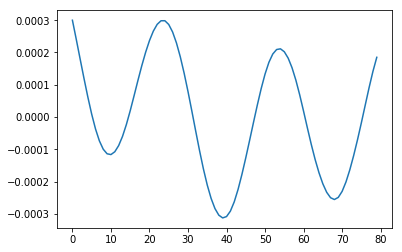

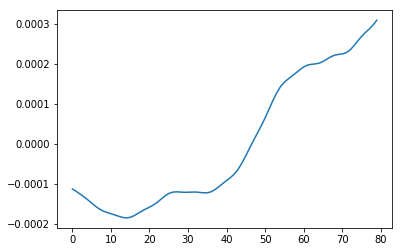

(900, 6)


In [324]:
#buildig the train matrix and labels
yes_oxy_contents = sio.loadmat('NIRSoxy_yes_signal.mat')
no_oxy_contents = sio.loadmat('NIRSoxy_no_signal.mat')
channels_no=no_oxy_contents["no_signal"]
channels_yes=yes_oxy_contents["yes_signal"]
#peak on NIRS
pick_yes_oxy_contents = sio.loadmat('pick_NIRSOxy_yes_signal.mat')["f_cell"]
pick_no_oxy_contents = sio.loadmat('pick_NIRSoxy_no_signal.mat')["f_cell"]

#explore with Mean_shift


# yes signals
channels_structure_yes_OXY=export_signals(channels_yes)
channels_structure_yes_OXY_new=[];

#using PCA 
for time_instace in channels_structure_yes_OXY:
    pca = PCA(n_components=1)
    time_instace_reduced=pca.fit_transform(time_instace.T);
    channels_structure_yes_OXY_new.append(time_instace_reduced.T);
channels_structure_yes_OXY_new=np.concatenate(channels_structure_yes_OXY_new,axis=0);

# dim(channels_structure_yes_OXY_new) = "number_of_reduced_sample" X "time_lenght"
# if n_components=1 =" 30 X 80

bandwidth = estimate_bandwidth(channels_structure_yes_OXY_new, quantile=0.2, n_samples=len(channels_structure_yes_OXY_new));
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True);
ms.fit(channels_structure_yes_OXY_new)
cluster_centers = ms.cluster_centers_
plt.plot(cluster_centers.T)
plt.show()





# no signals
channels_structure_no_OXY=export_signals(channels_no)

channels_structure_no_OXY_new=[];
for time_instace in channels_structure_no_OXY:
    pca = PCA(n_components=1)
    time_instace_reduced=pca.fit_transform(time_instace.T);
    channels_structure_no_OXY_new.append(time_instace_reduced.T);
channels_structure_no_OXY_new=np.concatenate(channels_structure_no_OXY_new,axis=0);

# dim(channels_structure_no_OXY_new) = "number_of_reduced_sample" X "time_lenght"
# if n_components=1 =" 30 X 80

bandwidth = estimate_bandwidth(channels_structure_no_OXY_new, quantile=0.2, n_samples=len(channels_structure_no_OXY_new));
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True);
ms.fit(channels_structure_no_OXY_new)
cluster_centers = ms.cluster_centers_

plt.plot(cluster_centers.T)
plt.show()




########################################    fino a qui 




    #select which feature select
    
feature_dictionary = {
        "fft_max_frequencies" : 1, 
         "mean" : 1, 
         "variance" : 1,
         "crest_factor" : 1,
         "mean_SHIFT": 1
         }



train_TX_yes_deoxy,labels_yes=get_train_matrix(channels_yes, feature_dictionary,"Yes",pick_yes_oxy_contents);
train_TX_no_deoxy,labels_no=get_train_matrix(channels_no, feature_dictionary,"No",pick_yes_oxy_contents);


train_TX=np.concatenate((train_TX_yes_deoxy,train_TX_no_deoxy,),axis=0)

print(train_TX.shape)
labels=np.concatenate((labels_yes,labels_no),axis=0)

# SVM on oxy

In [61]:
degrees = range(2,3)
C_parameters= np.linspace(0.1,5,10)
k_fold=8 # number of k sub-folders to divide the set
seed = 2
max_iters = 1000
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)

best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX, degrees, C_parameters, kernel_types, k_fold, seed, max_iters)



(900, 6)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.455357142857 0.506345177665
>> Type of Kernel  rbf <<
0.455357142857 0.506345177665
>> Type of Kernel  sigmoid <<
0.455357142857 0.506345177665
>> Penalty parameter C 0.644444444444 <<
>> Type of Kernel  linear <<
0.455357142857 0.506345177665
>> Type of Kernel  rbf <<
0.455357142857 0.506345177665
>> Type of Kernel  sigmoid <<
0.455357142857 0.506345177665
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
0.455357142857 0.506345177665
>> Type of Kernel  rbf <<
0.455357142857 0.506345177665
>> Type of Kernel  sigmoid <<
0.455357142857 0.506345177665
>> Penalty parameter C 1.73333333333 <<
>> Type of Kernel  linear <<
0.455357142857 0.506345177665
>> Type of Kernel  rbf <<
0.455357142857 0.506345177665
>> Type of Kernel  sigmoid <<
0.455357142857 0.506345177665
>> Penalty parameter C 2.27777777778 <<
>> Type of Kernel  linear <<
0.455357142857 0.506345177665
>> Type of Kernel  rbf <<


0.464285714286 0.505076142132
>> Type of Kernel  sigmoid <<
0.464285714286 0.505076142132
>> Penalty parameter C 5.0 <<
>> Type of Kernel  linear <<
0.464285714286 0.505076142132
>> Type of Kernel  rbf <<
0.464285714286 0.505076142132
>> Type of Kernel  sigmoid <<
0.464285714286 0.505076142132
--- Fold 4 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.571428571429 0.541878172589
>> Type of Kernel  rbf <<
0.544642857143 0.534263959391
>> Type of Kernel  sigmoid <<
0.517857142857 0.517766497462
>> Penalty parameter C 0.644444444444 <<
>> Type of Kernel  linear <<
0.571428571429 0.541878172589
>> Type of Kernel  rbf <<
0.544642857143 0.534263959391
>> Type of Kernel  sigmoid <<
0.517857142857 0.517766497462
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
0.571428571429 0.541878172589
>> Type of Kernel  rbf <<
0.544642857143 0.534263959391
>> Type of Kernel  sigmoid <<
0.517857142857 0.517766497462
>> Penalty parameter C 1.73333333333 <<
>> Type of Ker

# EEG 

In [170]:
yes_EEG_contents = sio.loadmat('EEGyes_signal.mat')
no_EEG_contents = sio.loadmat('EEGno_signal.mat')

channels_no_EEG=no_EEG_contents["no_signal"]
channels_yes_EEG=yes_EEG_contents["yes_signal"]

pick_yes_EEG_contents = sio.loadmat('pick_NIRSdxy_yes_signal.mat')["f_cell"]
pick_no_EEG_contents = sio.loadmat('pick_NIRSdxy_no_signal.mat')["f_cell"]

# select which feature select
feature_dictionary = {
        "fft_max_frequencies" : 1, 
         "mean" : 1, 
         "variance" : 1,
         "crest_factor" : 1
         }



train_TX_yes_EEG,EEG_yes_labels=get_train_matrix(channels_yes_EEG, feature_dictionary,"Yes",pick_yes_EEG_contents);
train_TX_no_EEG,EEG_no_labels=get_train_matrix(channels_no_EEG, feature_dictionary,"No",pick_no_EEG_contents);



train_TX=np.concatenate((train_TX_yes_EEG,train_TX_no_EEG,),axis=0)

print(train_TX.shape)
labels=np.concatenate((EEG_yes_labels,EEG_no_labels),axis=0)



(780, 6)


In [8]:
C_parameters= np.linspace(0.1,5,10)
k_fold=5 # number of k sub-folders to divide the set
seed = 2
max_iters = 100
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)

best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX, C_parameters, kernel_types, k_fold, seed, max_iters)



    

(780, 6)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.99358974359 1.0
>> Type of Kernel  rbf <<
0.487179487179 0.503205128205
>> Type of Kernel  sigmoid <<
0.487179487179 0.503205128205
>> Penalty parameter C 0.644444444444 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.487179487179 1.0
>> Type of Kernel  sigmoid <<
0.487179487179 0.503205128205
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.5 1.0
>> Type of Kernel  sigmoid <<
0.487179487179 0.503205128205
>> Penalty parameter C 1.73333333333 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.5 1.0
>> Type of Kernel  sigmoid <<
0.487179487179 0.503205128205
>> Penalty parameter C 2.27777777778 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.5 1.0
>> Type of Kernel  sigmoid <<
0.487179487179 0.503205128205
>> Penalty parameter C 2.82222222222 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of

1.0 1.0
>> Type of Kernel  rbf <<
0.423076923077 1.0
>> Type of Kernel  sigmoid <<
0.429487179487 0.517628205128
>> Penalty parameter C 2.82222222222 <<
>> Type of Kernel  linear <<
0.980769230769 0.99358974359
>> Type of Kernel  rbf <<
0.423076923077 1.0
>> Type of Kernel  sigmoid <<
0.429487179487 0.517628205128
>> Penalty parameter C 3.36666666667 <<
>> Type of Kernel  linear <<
0.980769230769 0.99358974359
>> Type of Kernel  rbf <<
0.423076923077 1.0
>> Type of Kernel  sigmoid <<
0.429487179487 0.517628205128
>> Penalty parameter C 3.91111111111 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.423076923077 1.0
>> Type of Kernel  sigmoid <<
0.429487179487 0.517628205128
>> Penalty parameter C 4.45555555556 <<
>> Type of Kernel  linear <<
1.0 1.0
>> Type of Kernel  rbf <<
0.423076923077 1.0
>> Type of Kernel  sigmoid <<
0.429487179487 0.517628205128
>> Penalty parameter C 5.0 <<
>> Type of Kernel  linear <<
0.980769230769 0.991987179487
>> Type of Kernel  rbf <<
0.

In [11]:
best_C=0.1;
best_kernel_type='linear'
print(train_TX.shape[0])

780


In [111]:
def spli_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
    

In [108]:
seed=2;
v=[1,2,3,4,5,6,7,8]
v=np.reshape(v,(len(v),1));
[i1,i2]=spli_matrix_two_blocks(v,0.1,0.2,seed)

print(i1)

v1=v[i1]
v2=v[i2]
print(v2)
print(v1)


>>>>>>>>>>>ERROR:Not valid splitting percentage


TypeError: 'NoneType' object is not iterable

In [40]:
print(v1)
print(v2)

[4 1 9 5 0 7 2 3]
[ 6 10  8]


In [172]:
from sklearn import svm
best_C=0.1;
seed=[123,12,3,4,2,1]
best_kernel_type='linear'
dataset_length=train_TX.shape[0];
for single_seed in seed:
    [i1,i2]=spli_matrix_two_blocks(train_TX,0.021,0.979,single_seed )
    train=train_TX[i1,:]
    labels_train=labels[i1]
    test= train_TX[i2,:]
    labels_test=labels[i2]
    clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)

    print(labels_train)
    clf.fit(train, labels_train)  
    predicted_labels= clf.predict(test)


    SVM_accuracy=get_accuracy(predicted_labels, labels_test)
    print(SVM_accuracy)
    

780
[ 1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.]
0.493455497382
780
[ 1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
0.486910994764
780
[ 0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  1.]
0.488219895288
780
[ 1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
0.485602094241
780
[ 0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.]
0.488219895288
780
[ 1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
0.496073298429


In [10]:
yes_EEG_contents = sio.loadmat('EEGyes_signal.mat')
no_EEG_contents = sio.loadmat('EEGno_signal.mat')

channels_no_EEG=no_EEG_contents["no_signal"]
channels_yes_EEG=yes_EEG_contents["yes_signal"]

pick_yes_EEG_contents = sio.loadmat('pick_NIRSdxy_yes_signal.mat')["f_cell"]
pick_no_EEG_contents = sio.loadmat('pick_NIRSdxy_no_signal.mat')["f_cell"]

# select which feature select
feature_dictionary = {
        "fft_max_frequencies" : 0, 
         "mean" : 1, 
         "variance" : 1,
         "crest_factor" : 1
         }



train_TX_yes_EEG,EEG_yes_labels=get_train_matrix(channels_yes_EEG, feature_dictionary,"Yes",pick_yes_EEG_contents);
train_TX_no_EEG,EEG_no_labels=get_train_matrix(channels_no_EEG, feature_dictionary,"No",pick_no_EEG_contents);



train_TX=np.concatenate((train_TX_yes_EEG,train_TX_no_EEG,),axis=0)

print(train_TX.shape)
labels=np.concatenate((EEG_yes_labels,EEG_no_labels),axis=0)




(780, 3)


In [12]:
from sklearn import svm

clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf.fit(train_TX, labels)  
predicted_labels= clf.predict(train_TX)
SVM_accuracy=get_accuracy(predicted_labels, labels)
print(SVM_accuracy)

0.511538461538


# Logistic Regression

In [ ]:
# cross validation

degrees = range(2,7)
lambdas = np.logspace(-8,-2,6)
k_fold=2
seed = 2
max_iters = 5000
print(train_TX.shape)

best_deg,best_lambda, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_logistic_regularized(labels,train_TX, degrees, lambdas, k_fold, seed, max_iters)


(780, 19)
--- Fold 0 ---
++ Degree 2 ++
>> Lambda 1e-08 <<
0.492307692308
>> Lambda 1.58489319246e-07 <<
0.492307692308
>> Lambda 2.51188643151e-06 <<
0.492307692308
>> Lambda 3.98107170553e-05 <<
0.492307692308
>> Lambda 0.00063095734448 <<
0.492307692308
>> Lambda 0.01 <<
0.492307692308
++ Degree 3 ++
>> Lambda 1e-08 <<


In [15]:
#logistic regression
train_TX = add_powers(train_TX,best_deg )
train_TX= add_ones(train_TX)
logreg=linear_model.LogisticRegression(C=1/best_lambda, class_weight="balanced",max_iter=max_iters)
logreg.fit(train_TX,labels)
predicted_labels= logreg.predict(train_TX)
logreg_accuracy=get_accuracy(predicted_labels, labels)
print(logreg_accuracy)





0.50641025641


# KNN

In [ ]:
#KNN 
clf = neighbors.KNeighborsClassifier(200)
clf.fit(train_TX, labels)
predicted_labels= clf.predict(train_TX)
KNN_accuracy=get_accuracy(predicted_labels, labels)
print(KNN_accuracy)

